In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### geojson with PLZs
import folium
import branca.colormap as cm
import geopandas as gpd
from geopandas.tools import sjoin
import geopandas._compat
from shapely.geometry import Point, Polygon
import pyproj
import rtree

#PCA as best practice to reduce dimensionality first
#as well as check for fitting amount of Gaussians / clusters
from sklearn.decomposition import PCA

#skaler
from sklearn.preprocessing import StandardScaler
#kmeans (hard)
from sklearn.cluster import KMeans
#kmeans with expectation maximization (hard)
from sklearn.metrics import pairwise_distances_argmin
#GMM (soft)
from sklearn.mixture import GaussianMixture


In [2]:
path_output=os.path.join(os.getcwd(), '../data/output/')

## Data preparation

In [22]:
df = pd.read_csv(os.path.join(path_output, "Trips.csv"))

In [23]:
df = df.drop(['Unnamed: 0'], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567439 entries, 0 to 567438
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   p_bike_racks_start     567439 non-null  int64  
 1   p_spot_start           567439 non-null  bool   
 2   p_booked_bikes_start   567439 non-null  int64  
 3   p_place_type_start     567439 non-null  int64  
 4   datetime_start         567439 non-null  object 
 5   b_number_start         567439 non-null  int64  
 6   p_uid_start            567439 non-null  int64  
 7   p_bikes_start          567439 non-null  int64  
 8   p_lat_start            567439 non-null  float64
 9   b_electric_lock_start  567439 non-null  bool   
 10  b_bike_type_start      567439 non-null  int64  
 11  p_name_start           567439 non-null  object 
 12  p_free_racks_start     567439 non-null  int64  
 13  b_lock_types_start     567439 non-null  object 
 14  p_number_start         567377 non-nu

Text(0.5, 1.0, 'January')

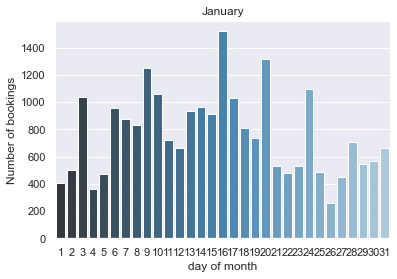

In [25]:
df["datetime_start"] = pd.to_datetime(df["datetime_start"].astype(str), format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_full = df


#Distribution Number of bookings per month
# df_full.datetime_start.dt.day.value_counts()
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 1].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('January')


### Creating feature PLZ (post code) to further interpret trip types later on

In [26]:
## create geopandas df for start locations
geo_trips_start = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.p_lng_start, df.p_lat_start)).copy()

geo_trips_start.head(2)
geo_trips_start.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 567439 entries, 0 to 567438
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   p_bike_racks_start     567439 non-null  int64         
 1   p_spot_start           567439 non-null  bool          
 2   p_booked_bikes_start   567439 non-null  int64         
 3   p_place_type_start     567439 non-null  int64         
 4   datetime_start         567439 non-null  datetime64[ns]
 5   b_number_start         567439 non-null  int64         
 6   p_uid_start            567439 non-null  int64         
 7   p_bikes_start          567439 non-null  int64         
 8   p_lat_start            567439 non-null  float64       
 9   b_electric_lock_start  567439 non-null  bool          
 10  b_bike_type_start      567439 non-null  int64         
 11  p_name_start           567439 non-null  object        
 12  p_free_racks_start     567439 non-nu

In [27]:
## Import geodata of dresden (PLZ based
# https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/export/?q=dresden&refine.note=Dresden
plz_df = gpd.read_file('../data/input/geodata/dresden_PLZ.geojson')

plz_df.head(2)

,note,plz,geometry
0,Dresden,01127,"POLYGON ((13.73703 51.09358, 13.73729 51.09389..."
1,Dresden,01328,"POLYGON ((13.84011 51.03656, 13.84056 51.03668..."


In [28]:
### get center of geodata
def get_center(gpd_df):

    x_map = gpd_df.centroid.x.mean()
    y_map = gpd_df.centroid.y.mean()
    
    return [y_map, x_map]

In [29]:
## join post codes to df based on geometry point
df_plz = gpd.sjoin(geo_trips_start, plz_df, op='within')

C:\Users\x250\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [30]:
## drop unnecessary columns 
df = df_plz.drop(['index_right', 'note'], axis=1)
df['plz'] = df['plz'].astype('int')
df.head(5)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,month,booking_date,weekdays,hour,24_sum,6_sum,2_sum,1_sum,geometry,plz
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,1,2019-01-20 00:00:00,6,0,265,36,19,8,POINT (13.75038 51.07126),1099
11,0,True,0,0,2019-01-20 00:39:00,93644,10299599,2,51.067980,False,...,1,2019-01-20 00:00:00,6,0,265,33,17,17,POINT (13.74754 51.06798),1099
43,0,True,0,0,2019-01-20 04:46:00,93238,176054,4,51.068905,False,...,1,2019-01-20 00:00:00,6,4,265,33,4,3,POINT (13.75898 51.06891),1099
47,0,True,0,0,2019-01-20 06:22:00,93677,176054,3,51.068905,False,...,1,2019-01-20 00:00:00,6,6,265,93,21,1,POINT (13.75898 51.06891),1099
61,0,False,0,12,2019-01-20 08:38:00,93530,12099153,1,51.067046,False,...,1,2019-01-20 00:00:00,6,8,265,93,25,20,POINT (13.75183 51.06705),1099


In [31]:
def generateBaseMap(default_location=get_center(plz_df), default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map


In [32]:
from folium.plugins import HeatMap
df_copy = df
df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=df_copy[['p_lat_start', 'p_lng_start', 'count']].groupby(['p_lat_start', 'p_lng_start']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [33]:
import folium
import math
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


### Getting rid of outliers in order to improve clustering quality

In [34]:
df.trip_duration.describe()

count    566538.000000
mean         19.442525
std          47.886097
min           2.000000
25%           4.000000
50%           9.000000
75%          17.000000
max        1320.000000
Name: trip_duration, dtype: float64

As we can see the trip duration has a max value of 1320 minutes which is almost one day, with a mean duration of 19.45 minutes and a standard deviation of 47.89 minutes. We'll use a rule of thumb and discard trips with a trip duration higher than the triple standard deviation (143.658291).

In [35]:
df = df[df['trip_duration'] <= 144]
df.head(2)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,booking_date,weekdays,hour,24_sum,6_sum,2_sum,1_sum,geometry,plz,count
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,2019-01-20 00:00:00,6,0,265,36,19,8,POINT (13.75038 51.07126),1099,1
11,0,True,0,0,2019-01-20 00:39:00,93644,10299599,2,51.067980,False,...,2019-01-20 00:00:00,6,0,265,33,17,17,POINT (13.74754 51.06798),1099,1


In [36]:
df.trip_duration.describe()
print("the amount of discarded trips is: ",  566538-555718, "\nPercentage of :", (566538-555718)/566538 )

the amount of discarded trips is:  10820 
Percentage of : 0.019098454119582445


In [37]:
print(df.p_number_start.unique())
#161 stationen
#https://www.stura.htw-dresden.de/stura/ref/verwaltung/ticket/nachrichten/studentinnen-und-studenten-radeln-zukuenftig-kostenlos

[    0.  4484.  4312.  4327.  4361.  4482.  4374.  4360.  4376.  4423.
  4378.    nan  4486.  4402.  4464.  4417.  4380.  4459.  4450.  4463.
  4441.  4452.  4345.  4480.  4350.  4313.  4340.  4349.  4323.  4455.
  4462.  4453.  4314.  4379.  4460.  4344.  4418.  4448.  4439.  4466.
  4420.  4419.  4509.  4364.  4367.  4483.  4438.  4481.  4436.  4437.
  4503.  4485.  4507.  4373.  4403.  4302.  4432.  4421.  4469.  4332.
  4308.  4401.  4306.  4442.  4422.  4404.  4341.  4301.  4353.  4310.
  4309.  4348.  4382.  4470.  4435.  4352.  4383.  4372.  4461.  4351.
  4392.  4391.  4326.  4399.  4338.  4393.  4319.  4425.  4424.  4328.
  4397.  4398.  4500.  4389.  4394.  4468.  4396.  4388.  4387.  4465.
  4395.  4325.  4339.  4315.  4300.  4413.  4411.  4426.  4343.  4408.
  4303.  4412.  4416.  4415.  4496.  4447.  4410.  4467.  4414.  4406.
  4508. 99970.  4458.  4451.  4491.  4384.  4457.  4502.  4346.  4322.
  4405.  4409.  4337.  4317.  4334.  4446.  4333.  4336.  4427.  4347.
  4385

In [88]:
df.groupby('plz').count().sort_values(ascending=False)


TypeError: sort_values() missing 1 required positional argument: 'by'

## Task description - Cluster analysis

- Based on the bike rental demand patterns, can you identify clusters of **trip types and/or customer types**? 
- How would you **label** these clusters? 
- Can you identify **hot spots for vehicle availability and demand in spatial resolution**?
--> availability start_points centroids
--> demand end points centroids
- Method 1: soft-clustering 
- Method 2: hard-clustering
- Create **visual comparison** of both methods 


## applications of clustering
- Determine appropriate product pricing.  --> trip_duration
- Develop customized marketing campaigns. --> Customer_types
- Design an optimal distribution strategy. --> hot spots
- Choose specific product features for deployment.  -->  b_bike_type_start: Welche werden an Station (p_name) eher zuerst ausgeliehen?
- Prioritize new product development efforts.

#### Similar paper:
--> difference of usage patterns among user groups, turnover rate, travel time and distance
--> combined with spatial POI data with categories like: Catering, Hotel, Shopping, Living Service,
Tourist Sites, Leisure and Entertainment, Education, Medical, Trafficc Facilities, Financial Institutions,
Real Estate, Corporations, and Government Institutions.

### Columns for trip types:
--> clustering PLZ vs trip duration

- stations like University or main station

- trip duration
- bike IDs
- datetime
- weather data
- PLZ information
- 

### Columns for customer types:
--> mit PCA auf 2 dimensional für plot
--> clustering hour of trip vs trip duration
--> clustering weekday of trip vs trip duration
--> clustering month of trip vs trip duration
--> clustering weather features (2-3) vs trip duration --> mit PCA auf 2 dimensional für plot
- stations like University or main station
- trip duration
- user IDs
- datetime
- weather data
- PLZ information
- 

### Columns for spatial Vehicle availability & demand

--> longitude und latitude clustern und centroids plotten in map je für demand und availability
- PLZ information
- bike id
- station information
- weather data
- datetime
- sum 1h, 2h, 6h, 24h
- hexagons



## Which  features could be relevant for our clustering approaches?

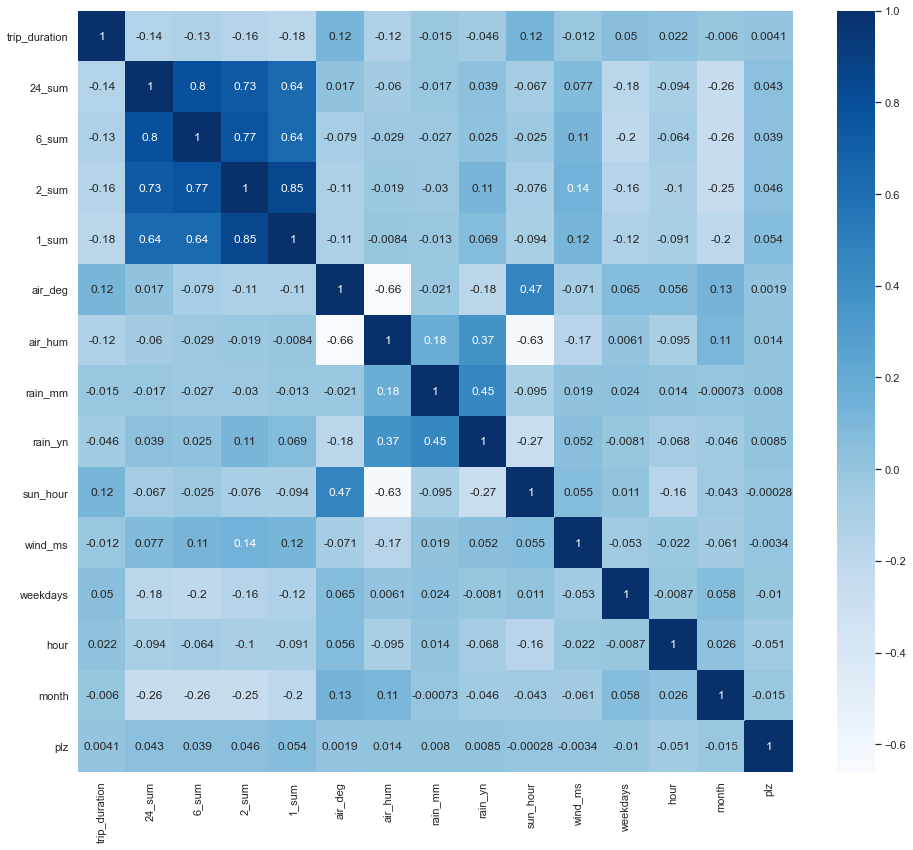

In [147]:
#Using Pearson Correlation to check for features with corr above |0.1| to ??_sum or trip_duration
plt.figure(figsize=(16,14))
cor = df[['trip_duration', '24_sum','6_sum','2_sum','1_sum', 'air_deg', 'air_hum', 'rain_mm', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month','plz']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()


Obviously the ??_sum features are highly correlated to each other. We will not use them for any clustering methods, yet it is interesting to take a look at their correlations with possibly clustered features. They provide us with insights regarding features with high influence on bike demand. Additionally, we take a look at features correlations with the trip_duration, as this an important factor for NextBike revenue stream. Based on the observable correlations we will cluster the following combinations of features and will not consider rain_mm and air_hum for further clustering models.  


These clustering approaches should provide us insights into **customer as well as trip types**:
- trip duration with all remaining features air_deg, rain_yn, sun_hour, wind_ms, weekdays, hour, month and plz
- trip duration with remaining weather features air_deg, rain_yn, sun_hour, wind_ms
- trip duration with feature hour to assess if there are customer types which vary in across daily temporal resolution
- trip duration with feature weekdays to assess if there are customer types which vary across weekly temp. resolution
- trip duration with feature month to asses if there are customer types which vary across monthly temp. resolution
- to further analyze our trip types, we will utilize the feature plz to determine if certain trip types start predominantly wihtin specific post code regions

Furthermore we will gain insights into **bike demand and availability hot spots** across spatial resolutions by clustering location data of trip starts and trip ends:
- bike demand with location features 'p_lat_start', 'p_lng_start' to assess if there are hot spots in bike demand
- bike availability with location features 'p_lat_end', 'p_lng_end' to assess if there are hot spots in bike availability


In [38]:
### features we'll use for clustering
describe = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month','plz', 'p_lat_start', 'p_lng_start', 'p_lat_end', 'p_lng_end']]
df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month','plz', 'p_lat_start', 'p_lng_start', 'p_lat_end', 'p_lng_end']].head(5)

print('Mean degree Celsius:',describe['air_deg'].mean(), 
      '\nMean rain yes / no:',describe['rain_yn'].mean(),
      '\nMean Sun minutes per hour:', describe['sun_hour'].mean(), 
      '\nMean wind m/s:', describe['wind_ms'].mean(),
      '\nMean trip duration:', describe['trip_duration'].mean(), 
      '\nCenter of all plz:', get_center(plz_df))

Mean degree Celsius: 14.796545370141132 
Mean rain yes / no: 0.08044565768970309 
Mean Sun minutes per hour: 20.732191507203293 
Mean wind m/s: 4.186388420026968 
Mean trip duration: 13.994122918458643 
Center of all plz: [51.05551186178577, 13.767745080828751]


In [39]:
### Kmeans ++ clustering
from sklearn.cluster import KMeans

def clusteringLoss(data, plotName):
    #SCALE DATA
    scaler = StandardScaler()
    scaler.fit(data)
    X_scaled = scaler.transform(data)
    X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns, index=data.index)

    #CLUSTERING
    #create clustering and losses for 1 to 20 clusters
    kclusters = []
    losses = []
    for i in range(1, 20):
        model = KMeans(n_clusters=i+1, init = 'k-means++', random_state = 42)
        model.fit(X_scaled)
        kclusters.append(i+1)
        losses.append(model.inertia_)
        out = 'Clusterings done: '+str(i+1)
        #status updates
        print(out, end='\r')
    #df_losses_clustertype[plotName]=losses
    
    #PLOTTING
    #plot loss for each number of clusters
    plt.figure(figsize=(10,5))
    plt.xlabel('# of Clusters')
    plt.ylabel('Loss')
    plt.title('Loss by # of Clusters in '+plotName)
    plt.plot(kclusters, losses)
    plt.savefig('Loss_Size_for_each_Number_of_Clusters_'+plotName+'.png')


def doKmeansPP(df,clustertype):
    #check for cluster type
    global plotName
    global data
    
    if clustertype == 'tripCustomerAll':
        print("Clustering trips/customer types using all features....")
        data = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month']]
        plotName = "Customer and trip types with all features"
        clusteringLoss(data, plotName)
        print("...finished clustering trips/customer types using all features.")
        
    elif clustertype == 'hourDuration':
        print("Clustering customer types using hours and trip duration...")
        data = df[['trip_duration', 'hour']]
        plotName = "Customer types based on hour and trip duration"
        clusteringLoss(data, plotName)
        print("...finished clustering customer types using hours and trip duration.")
    
    elif clustertype == 'monthDuration':
        print("Clustering customer types using months and trip duration...")
        data = df[['trip_duration', 'month']]
        plotName = "Customer types based on month and trip duration"    
        clusteringLoss(data, plotName)
        print("...finished clustering customer types using months and trip duration.")
        
    elif clustertype == 'weekdayDuration':
        print("Clustering customer types using weekdays and trip duration...")
        data = df[['trip_duration', 'weekdays']]
        plotName = "Customer types based on weekdays and trip duration"
        clusteringLoss(data, plotName)
        print("...finished clustering customer types using weekdays and trip duration.")
        
    elif clustertype == 'weatherDuration':
        print("Clustering customer types using weather data and trip duration...")
        data = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms']]
        plotName = "Customer types based on weather and trip duration"
        clusteringLoss(data, plotName)
        print("...finished clustering customer types using weather data and trip duration.")
# this cluster approach makes no sense.
#     elif clustertype == 'plzDuration':
#         print("Clustering trip types using plz and trip duration...")
#         data = df[['trip_duration', 'plz']]
#         plotName = "Trip types based on plz and trip duration"
#         clusteringLoss(data, plotName)
#         print("finished clustering trip types using plz and trip duration.")
        
    elif clustertype == 'bikeDemand':
        print("Clustering trip types bike demand using location data...")
        data = df[['p_lat_start', 'p_lng_start']]
        plotName = "Trip types: Spatial bike demand"
        clusteringLoss(data, plotName)
        print("... finished clustering trip types bike demand using location data.")
    
    elif clustertype == 'bikeAvailability':  
        print("Clustering trip types bike availability using location data...")
        data = df[['p_lat_end', 'p_lng_end']]
        plotName = "Trip types: Spatial bike availability"
        clusteringLoss(data, plotName)
        print("...clustering trip types bike availability using location data...")
    
    else:
        print('vo valid cluster type selcted. break process.')
        return

    
def createAllclusters(df, clusterlist):
    i = 0
    for cluster in clusterlist:
        i = i+1
        print("Computing element: ", i)
        doKmeansPP(df,cluster)
        
        

Computing element:  1
Clustering trips/customer types using all features....
...finished clustering trips/customer types using all features.
Computing element:  2
Clustering customer types using weather data and trip duration...
...finished clustering customer types using weather data and trip duration.
Computing element:  3
Clustering trip types bike demand using location data...
... finished clustering trip types bike demand using location data.
Computing element:  4
Clustering trip types bike availability using location data...
...clustering trip types bike availability using location data...
Computing element:  5
Clustering customer types using hours and trip duration...
...finished clustering customer types using hours and trip duration.
Computing element:  6
Clustering customer types using weekdays and trip duration...
...finished clustering customer types using weekdays and trip duration.
Computing element:  7
Clustering customer types using months and trip duration...
...finish

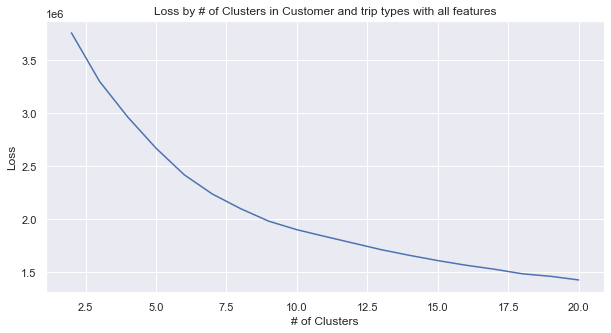

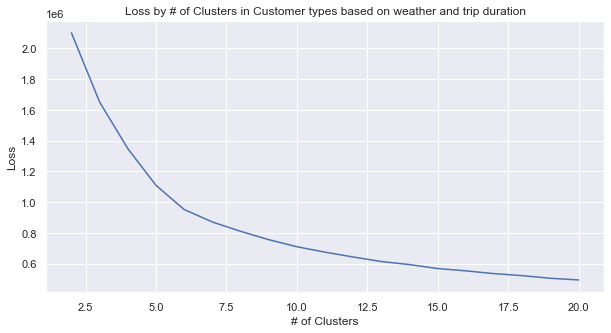

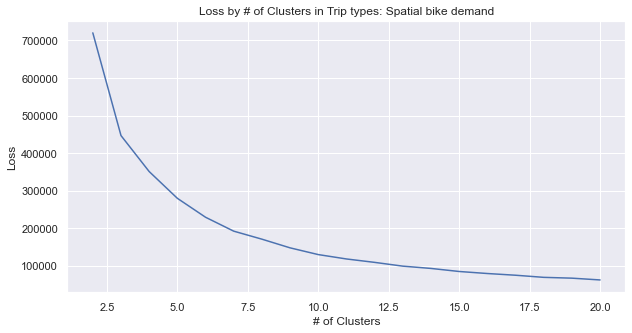

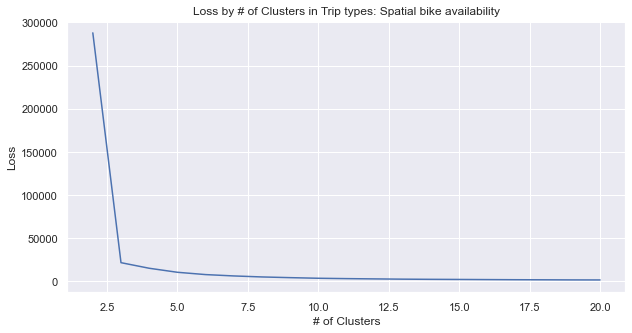

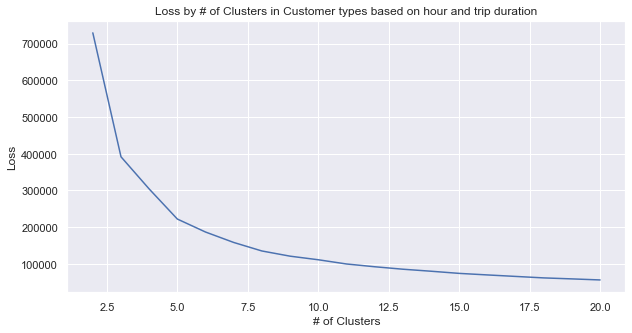

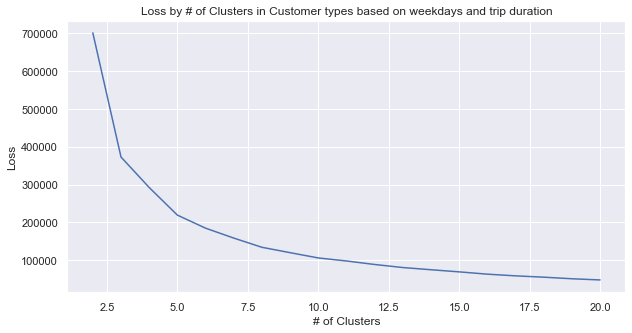

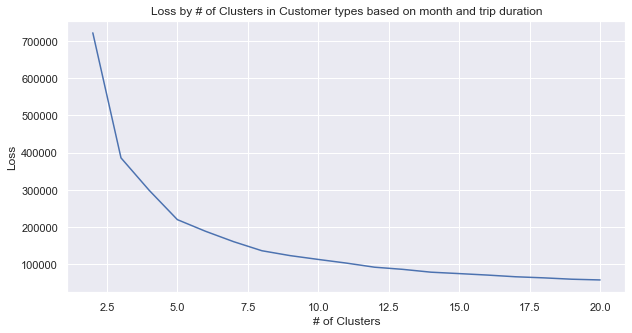

In [150]:
clusters=[]
clusters = ['tripCustomerAll', 'weatherDuration', 'bikeDemand', 'bikeAvailability', 'hourDuration', 'weekdayDuration', 'monthDuration']

createAllclusters(df, clusters)

### Let's plot those cluster (k chosen via elbow approach)

We choose a the follwing # of clusters for each clustering approach:
- k = 6 for trip duration + all features
- k = 6 for trip duration + weather features
- k = 7 for bike demand hot spots, we choose 161 since we want to compare actual with usage pattern derived stations
- k = 3 for bike availiability hot spots, we choose 161 since we want to compare actual with usage pattern derived stations
- k = 5 for trip duration + hour
- k = 5 for trip duration + weekday
- k = 5 for trip duration + month

In [63]:
clusters=[]
#clusters = ['tripCustomerAll', 'weatherDuration', 'bikeDemand', 'bikeAvailability', 'hourDuration', 'weekdayDuration', 'monthDuration',  'plzDuration']
clusters = ['hourDuration', 'weekdayDuration', 'monthDuration', 'bikeDemand', 'bikeAvailability']


def plotAllclusters(df, clustertype):
    i = 0
    #SCALE DATA
    df_centers = df[['p_lat_start', 'p_lng_start', 'p_lat_end', 'p_lng_end']]
    df_scale = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month', 'plz']]
    scaler = StandardScaler()
    scaler.fit(df_scale)
    X_scaled = scaler.transform(df_scale)
    X_scaled_df = pd.DataFrame(X_scaled, columns=df_scale.columns, index=df_scale.index)
    for cluster in clustertype:
        i = i+1
        print("Computing element: ", i)
        element = i
#         if cluster == 'tripCustomerAll':
#             print("plotting trips/customer types using all features....")
#             data = X_scaled_df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month','plz']]
#             plotName = "Customer and trip types with all features"
#             k = 6
#             standardPlot(element, k, data, 'hour', 'trip_duration', plotName)
#             print("...finished plotting trips/customer types using all features.")

        if cluster == 'hourDuration':
            print("Clustering customer types using hours and trip duration...")
            data = X_scaled_df[['trip_duration', 'hour']]
            plotName = "Customer types based on hour and trip duration"
            k = 5
            standardPlot(element, k, data, 'hour', 'trip_duration', plotName)
            print("...finished clustering customer types using hours and trip duration.")

        elif cluster == 'monthDuration':
            print("Plotting customer types using months and trip duration...")
            data = X_scaled_df[['trip_duration', 'month']]
            plotName = "Customer types based on month and trip duration"    
            k = 5
            standardPlot(element, k, data, 'month', 'trip_duration', plotName)
            print("...finished plotting customer types using months and trip duration.")

        elif cluster == 'weekdayDuration':
            print("Plotting customer types using weekdays and trip duration...")
            data = X_scaled_df[['trip_duration', 'weekdays']]
            plotName = "Customer types based on weekdays and trip duration"
            k = 5
            standardPlot(element, k, data, 'weekdays', 'trip_duration', plotName)
            print("...finished plotting customer types using weekdays and trip duration.")

#         elif clustertype == 'weatherDuration':
#             print("Plotting customer types using weather data and trip duration...")
#             data = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms']]
#             plotName = "Customer types based on weather and trip duration"
#             clusteringLoss(data, plotName)
#             print("...finished plotting customer types using weather data and trip duration.")

        elif cluster == 'plzDuration':
            print("Plotting trip types using plz and trip duration...")
            data = X_scaled_df[['trip_duration', 'plz']]
            plotName = "Trip types based on plz and trip duration"
            k = 5
            standardPlot(element, k, data, 'plz', 'trip_duration', plotName)
            print("finished plotting trip types using plz and trip duration.")

        elif cluster == 'bikeDemand':
            print("Clustering trip types bike demand using location data...")
            data = df_centers[['p_lat_start', 'p_lng_start']]
            plotName = "Trip types: Spatial bike demand"
            k = 161
            foliumPlot(element, k, data, 'p_lat_start', 'p_lng_start', plotName)
            htmlmap.save(plotName, '_folium.html')
            display(htmlmap)
            print("... finished clustering trip types bike demand using location data.")

        elif cluster == 'bikeAvailability':  
            print("Clustering trip types bike availability using location data...")
            data = df_centers[['p_lat_end', 'p_lng_end']]
            plotName = "Trip types: Spatial bike availability"
            k = 161
            foliumPlot(element, k, data, 'p_lat_end', 'p_lng_end', plotName)
            htmlmap.save(plotName, '_folium.html')
            display(htmlmap)
            print("...clustering trip types bike availability using location data...")

        else:
            print('no valid cluster type selcted. break process.')
            return
  
 #how to close folium map objects?            
            
def standardPlot(element, k, data, pX_col, pY_col, plotName):  
    #CLUSTERING
    km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    km.fit(data)
    km.predict(data)
    labels = km.labels_
    data['Cluster'] = labels

    #count of points in cluster
    df_t = pd.DataFrame(columns={'X', 'Y', 'COUNT', '%'}, index=np.arange(0, k))
    for i in range(0, k):
        #point in middle of cluster i 
        df_t.loc[i, 'X']=data[data['Cluster']==i][pX_col].mean()
        df_t.loc[i, 'Y']=data[data['Cluster']==i][pY_col].mean()
        #count of points in cluster i
        df_t.loc[i, 'COUNT']=int(data[data['Cluster']==i][pX_col].count())
        df_t.loc[i, '%']=int(data[data['Cluster']==i][pX_col].count()/len(data)*100)
    

    #PLOTTING
    plt.figure(figsize=(20,10))
    plt.scatter(data[pX_col], data[pY_col], c=labels.astype(np.float), edgecolor='none', cmap='rainbow', s=50)
    #count of points in cluster
    for i in range(0, k):
        plt.annotate(str(df_t.loc[i, 'COUNT'])+'('+str(df_t.loc[i, '%'])+'%)', (df_t.loc[i, 'X'], df_t.loc[i, 'Y']), fontsize=20, fontweight='bold')
    plt.xlabel(pX_col)
    plt.ylabel(pY_col)
    plt.title('K Means '+plotName, fontsize=14)
    plt.savefig('Cluster2d_'+str(k)+'_'+pX_col+'_'+pY_col+'_'+plotName+'.png', dpi=300)

def pcaFeaturePlot(element, k, data, pX_col, pY_col, plotName):
    #CLUSTERING
    X = data
    km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    km.fit(X)
    km.predict(X)
    labels = km.labels_
    data['Cluster'] = labels  
    
    #customer type analysis
    clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
    clusters.head()
    for c in clusters:
        grid= sns.FacetGrid(clusters, col='cluster')
        grid.map(plt.hist, c)
    
    #PCA for visualization
    #The dot product a\cdot b = |a||b|\cos \theta, so the scatter matrix records 
    #a scaled version of the cosine similarity of the features.  
    #Cosine similarity measures the extent to which two vectors point in the same direction, 
    #opposite direction, or whether they’re simply orthogonal.  
    #Thus, the scatter matrix asks the extent to which two features ‘point’ in the same direction, 
    #multiplied by the overall scale of the features.
    dist = 1 - cosine_similarity(X)

    pca = PCA(2)
    pca.fit(dist)
    X_PCA = pca.transform(dist)
    X_PCA.shape
    
    #plot pca visualization
    x, y = X_PCA[:, 0], X_PCA[:, 1]

    colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

    names = {0: 'who make all type of purchases', 
         1: 'more people with due payments', 
         2: 'who purchases mostly in installments', 
         3: 'who take more cash in advance', 
         4: 'who make expensive purchases',
         5:'who don\'t spend much money'}

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 13)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

        ax.legend()
        ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
    plt.show()
    
    

def foliumPlot(element, k, data, pX_col, pY_col, plotName):  
    global htmlmap
    #CLUSTERING
    km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    km.fit(data)
    km.predict(data)
    labels = km.labels_
    data['Cluster'] = labels
    
    #count cluster numbers
    df_t = pd.DataFrame(columns={'X', 'Y','COUNT', '%'}, index=np.arange(0, k))
    for i in range(0, k):
#         #point in middle of cluster i aka centroid
#         df_t.loc[i, 'X']=data[data['Cluster']==i][pX_col].mean()
#         df_t.loc[i, 'Y']=data[data['Cluster']==i][pY_col].mean()
        #count of points in cluster i
        df_t.loc[i, 'COUNT']=int(data[data['Cluster']==i][pX_col].count())
        df_t.loc[i, '%']=int(data[data['Cluster']==i][pX_col].count()/len(data)*100)
    
    #hot spots
    centroids = pd.DataFrame(km.cluster_centers_, columns = ['centroid_long', 'centroid_lat'])
    centroids['label'] = centroids.index
   
    htmlmap = generateBaseMap()
    #dd marker one by one on the map
    for i in range(0,len(centroids)):
        folium.Circle(radius=100,location=[centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']],
                                    popup=centroids.iloc[i]['label'],
                                    color='crimson', fill=False).add_to(htmlmap)
        #folium.Marker([centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']], popup=centroids.iloc[i]['label']).add_to(m)
 
    # Save it as html
   
    HeatMap(data=data[['p_lat_start', 'p_lng_start', 'count']].groupby(['p_lat_start', 'p_lng_start']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(htmlmap)
    htmlmap.save(path_output,plotName, '_folium.html')
    return htmlmap


Computing element:  1
Clustering customer types using hours and trip duration...


C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


...finished clustering customer types using hours and trip duration.
Computing element:  2
Plotting customer types using weekdays and trip duration...


C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


...finished plotting customer types using weekdays and trip duration.
Computing element:  3
Plotting customer types using months and trip duration...


C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


...finished plotting customer types using months and trip duration.
Computing element:  4
Plotting trip types using plz and trip duration...


C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


finished plotting trip types using plz and trip duration.


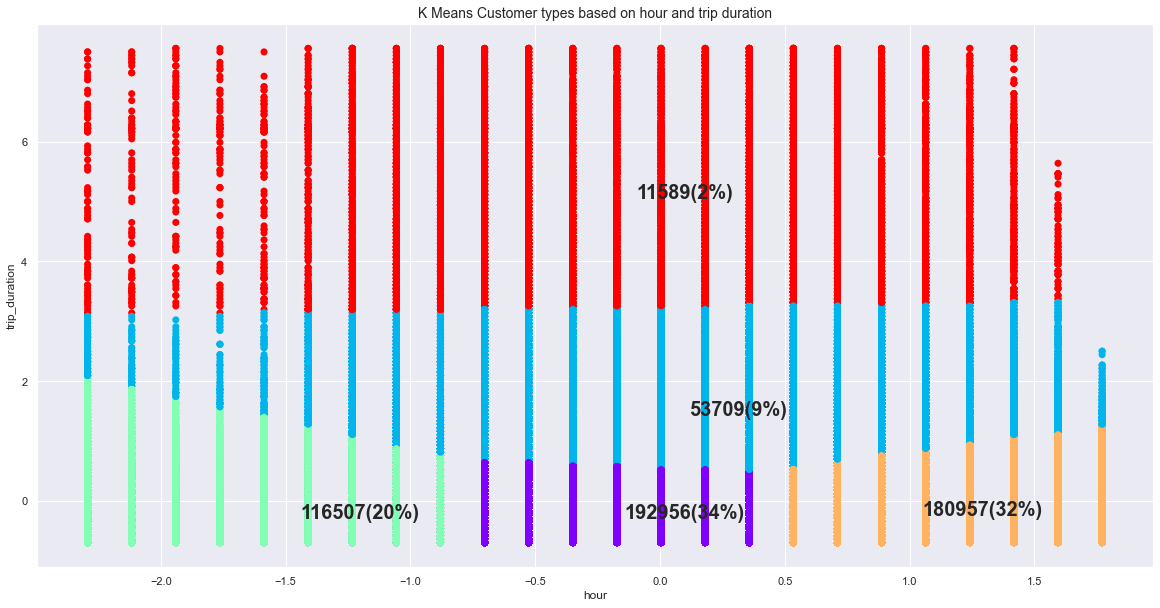

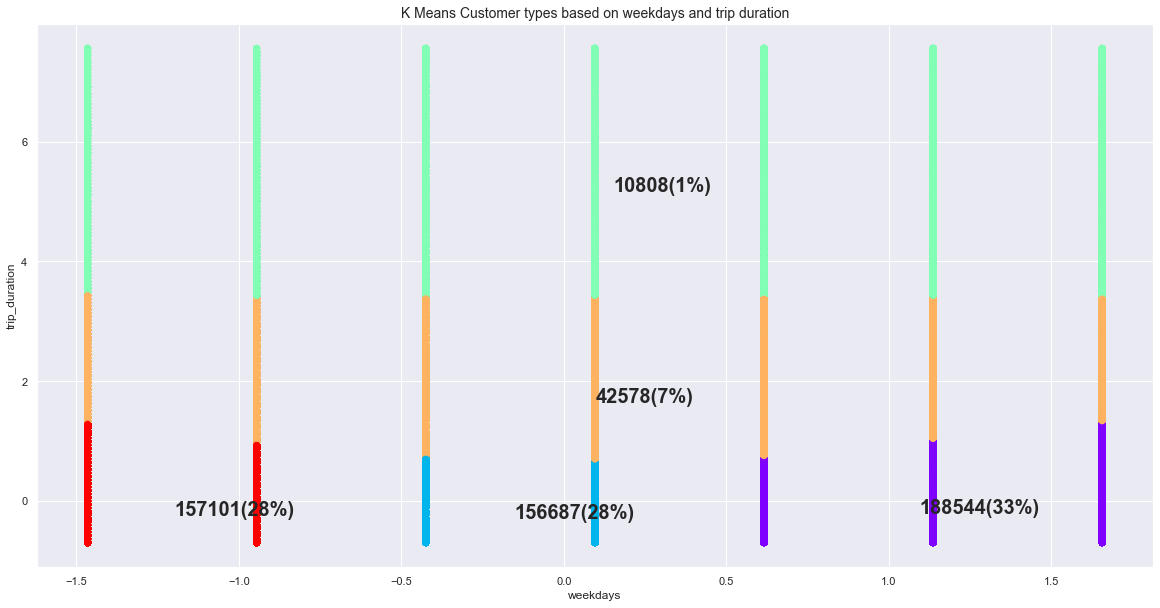

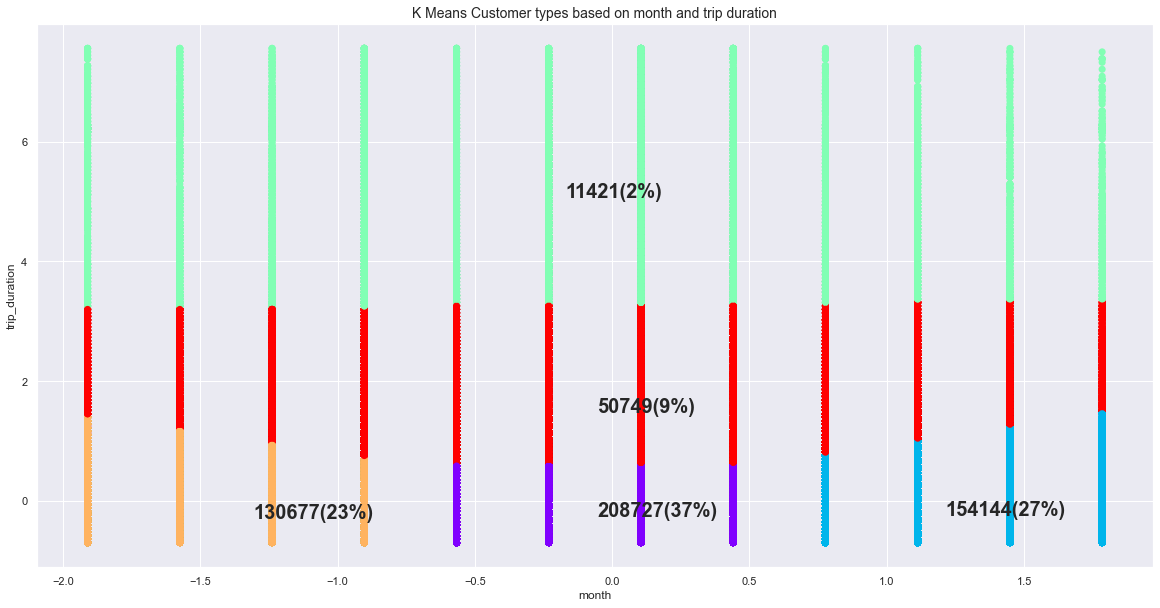

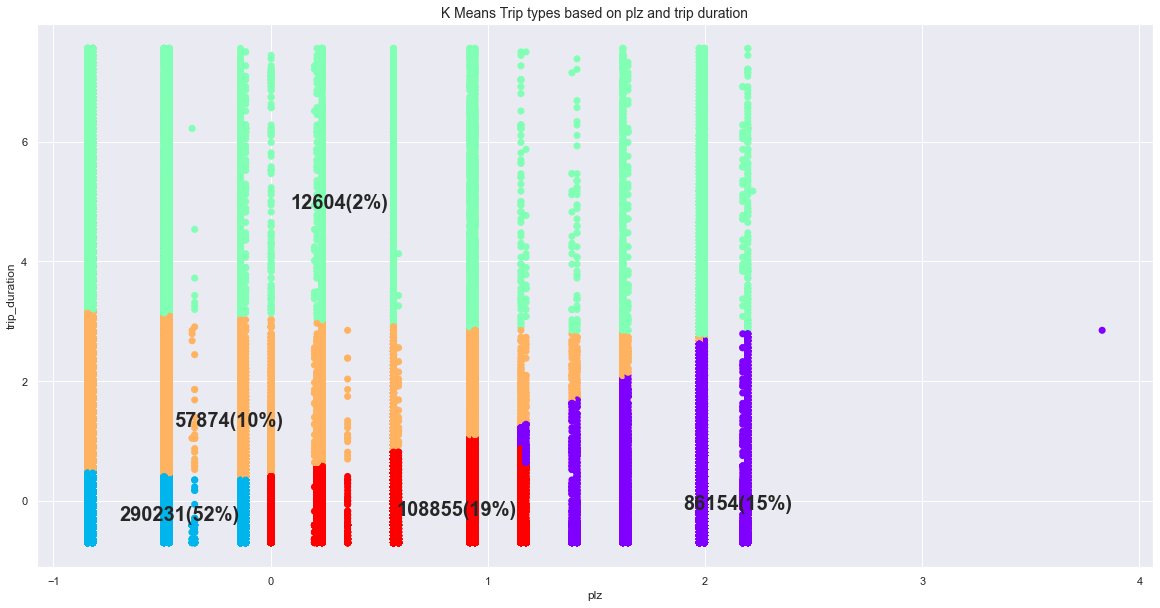

In [64]:
#clusters = []
clusters = ['hourDuration', 'weekdayDuration', 'monthDuration', 'plzDuration']
plotAllclusters(df, clusters)

In [58]:
### relevant data
df_centers = df[['p_lat_start', 'p_lng_start', 'p_lat_end', 'p_lng_end']]   

#first plot
data = df_centers[['p_lat_start', 'p_lng_start']]
plotName = "Trip types: Spatial bike demand"
k = 161
m.save(plotName, '_folium.html')
display(m)
print("... finished clustering trip types bike demand using location data.")

elif cluster == 'bikeAvailability':  
    print("Clustering trip types bike availability using location data...")
    data = df_centers[['p_lat_end', 'p_lng_end']]
    plotName = "Trip types: Spatial bike availability"
    k = 161
    foliumPlot(element, k, data, 'p_lat_end', 'p_lng_end', plotName)
    m.save(plotName, '_folium.html')
    display(m)
print("...clustering trip types bike availability using location data...")
def foliumPlot(element, k, data, pX_col, pY_col, plotName):  
global m
#CLUSTERING
km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
km.fit(data)
km.predict(data)
labels = km.labels_
data['Cluster'] = labels

#count cluster numbers
df_t = pd.DataFrame(columns={'X', 'Y','COUNT', '%'}, index=np.arange(0, k))
for i in range(0, k):
#         #point in middle of cluster i aka centroid
#         df_t.loc[i, 'X']=data[data['Cluster']==i][pX_col].mean()
#         df_t.loc[i, 'Y']=data[data['Cluster']==i][pY_col].mean()
    #count of points in cluster i
    df_t.loc[i, 'COUNT']=int(data[data['Cluster']==i][pX_col].count())
    df_t.loc[i, '%']=int(data[data['Cluster']==i][pX_col].count()/len(data)*100)

#hot spots
centroids = pd.DataFrame(km.cluster_centers_, columns = ['centroid_long', 'centroid_lat'])
centroids['label'] = centroids.index

htmlmap = generateBaseMap()
#dd marker one by one on the map
for i in range(0,len(centroids)):
    folium.Circle(radius=100,location=[centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']],
                                popup=centroids.iloc[i]['label'],
                                color='crimson', fill=False).add_to(htmlmap)
    #folium.Marker([centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']], popup=centroids.iloc[i]['label']).add_to(m)

# Save it as html

HeatMap(data=data[['p_lat_start', 'p_lng_start', 'count']].groupby(['p_lat_start', 'p_lng_start']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(htmlmap)
htmlmap.save(path_output,plotName, '_folium.html')
return htmlmap

m = htmlmap
display(m)

Computing element:  1
no valid cluster type selcted. break process.


NameError: name 'htmlmap' is not defined

In [62]:
plotAllclusters(df, 'bikeAvailability')

Computing element:  1
no valid cluster type selcted. break process.


In [60]:
#CLUSTERING
data = df[['p_lat_start', 'p_lng_start']]
plotName = "Trip types: Spatial bike demand"
k = 161

km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
km.fit(data)
km.predict(data)
labels = km.labels_
data['Cluster'] = labels

#hot spots
centroids = pd.DataFrame(km.cluster_centers_, columns = ['centroid_long', 'centroid_lat'])
centroids['label'] = centroids.index
# folium.Circle(
#     radius=100,
#     location=[45.5244, -122.6699],
#     popup='The Waterfront',
#     color='crimson',
#     fill=False,
# ).add_to(m)
# m = generateBaseMap()
#dd marker one by one on the map
for i in range(0,len(centroids)):
    folium.Marker([centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']], popup=centroids.iloc[i]['label']).add_to(m)

# Save it as html
HeatMap(data=df_copy[['p_lat_start', 'p_lng_start', 'count']].groupby(['p_lat_start', 'p_lng_start']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m)
display(m)
m.save(plotName, '_folium.html')
# path_map=os.path.join(os.getcwd(), "..", "data", "output", "choropleth_map.html")


C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'm' is not defined

In [89]:
#CLUSTERING
data = df[['p_lat_end', 'p_lng_end']]
plotName = "Trip types: Spatial bike demand"
k = 161

km = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
km.fit(data)
km.predict(data)
labels = km.labels_
data['Cluster'] = labels

#hot spots
centroids = pd.DataFrame(km.cluster_centers_, columns = ['centroid_long', 'centroid_lat'])
centroids['label'] = centroids.index
# folium.Circle(
#     radius=100,
#     location=[45.5244, -122.6699],
#     popup='The Waterfront',
#     color='crimson',
#     fill=False,
# ).add_to(m)
# m = generateBaseMap()
#dd marker one by one on the map
for i in range(0,len(centroids)):
    folium.Marker([centroids.iloc[i]['centroid_long'], centroids.iloc[i]['centroid_lat']], popup=centroids.iloc[i]['label']).add_to(m)

# Save it as html
HeatMap(data=df_copy[['p_lat_end', 'p_lng_end', 'count']].groupby(['p_lat_end', 'p_lng_end']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m)
display(m)
m.save(plotName, '_folium.html')

C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'm' is not defined

In [ ]:
#standard kmeans approach
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_full)
y_kmeans = kmeans.predict(df_full)
labels = kmeans.labels_

#Glue back to originaal data
df_full['clusters'] = labels

#Add the column into our list
duration_weather.extend(['clusters'])

#Lets analyze the clusters
print (df_full[duration_weather].groupby(['clusters']).mean())

#standard kmeans approach
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_full)
y_kmeans = kmeans.predict(df_full)
labels = kmeans.labels_

#Glue back to originaal data
df_full['clusters'] = labels

#Add the column into our list
duration_weather.extend(['clusters'])

#Lets analyze the clusters
print (df_full[duration_weather].groupby(['clusters']).mean())

## 1) Hard Clustering
- Kmeans: 
An iterative method, k-means algorithm is the most fundamental and most useful algorithm for
clustering [36]. For a given number of clusters, it can minimize the within-class sum of squares [37].
Its effciency to a great extent relies on the choice of the cluster centers. When the algorithm starts,
random procedures are applied to create starting clustering centers, then each observation is put
in its closest cluster. Therefore, the cluster centers are updated, and the entire process is repeated,
finally, objects are relocated by minimizing the distances of objects within clusters and maximizing the
distance of objects in different clusters.

- Expectation Maximization: 
A model-based clustering, EM clustering functions with a Gaussian mixture model. This model is
extended from the k-means algorithm [38]. K-means only takes into account the distance to the closest
cluster when assigning points to clusters. Yet EM clustering also computes the probability that a point
belongs to a cluster. As the probability depends on both the distance from the cluster center and the
spread (variance) of the cluster, a point that is closer to the centroid of one cluster than another may
well become more likely to belong to the latter cluster if it has a much higher spread [38].


### Weather features + trip duration

In [17]:
#Trip types clustering
duration_weather = ["trip_duration", "air_deg", "air_hum" , "rain_mm" , "rain_yn" , "sun_hour", "wind_ms"]
df_full = df[duration_weather]
df_full

#standardize StandardScaler
scaler = StandardScaler()
scaler.fit(df_full)
X_scaled = scaler.transform(df_full)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_full.columns, index=df_full.index)

In [45]:
#standard kmeans approach
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_full)
y_kmeans = kmeans.predict(df_full)
labels = kmeans.labels_

#Glue back to originaal data
df_full['clusters'] = labels

#Add the column into our list
duration_weather.extend(['clusters'])

#Lets analyze the clusters
print (df_full[duration_weather].groupby(['clusters']).mean())

C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


          trip_duration    air_deg    air_hum   rain_mm   rain_yn   sun_hour  \
clusters                                                                       
0             14.906776  19.788024  47.946432  0.000318  0.002850  50.915687   
1            163.329328  17.314945  57.031169  0.030263  0.059289  30.027227   
2             11.400240  11.798776  71.674500  0.054493  0.126796   2.708403   
3            472.453726  13.682937  67.893967  0.025307  0.063008  23.769178   

           wind_ms  
clusters            
0         4.363248  
1         4.145763  
2         4.081680  
3         3.691046  


Text(29.95656006944445, 0.5, 'Air deg')

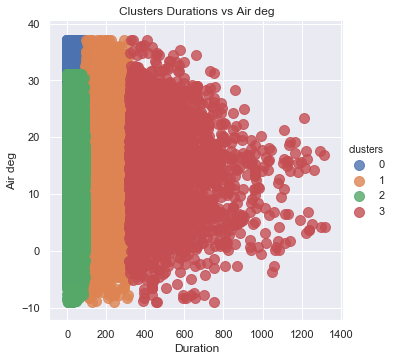

In [47]:
#Scatter plot of Wattage and Duration
sns.lmplot('trip_duration', 'air_deg', 
           data=df_full, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Durations vs Air deg')
plt.xlabel('Duration')
plt.ylabel('Air deg')

### post code + weather data

In [29]:
duration_PLZ_air_deg = ["trip_duration", "plz", "air_deg"]
df_full = df[duration_PLZ]
df_full

,trip_duration,plz
0,28.0,01099
11,18.0,01099
43,15.0,01099
47,13.0,01099
61,10.0,01099
...,...,...
383106,62.0,01108
117586,15.0,01127
173727,63.0,01465
299384,192.0,01465


In [34]:
#standardize StandardScaler
scaler = StandardScaler()
scaler.fit(df_full)
X_scaled = scaler.transform(df_full)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_full.columns, index=df_full.index)

#standard kmeans approach
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_full)
y_kmeans = kmeans.predict(df_full)
labels = kmeans.labels_

#Glue back to originaal data
df_full['clusters'] = labels

#Add the column into our list
duration_PLZ.extend(['clusters'])

#Lets analyze the clusters
print (df_full[duration_PLZ].groupby(['clusters']).mean())

#Scatter plot of Wattage and Duration
sns.lmplot('trip_duration', 'plz', 'air_deg', 
           data=df_full, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Durations vs plz')
plt.xlabel('Duration')
plt.ylabel('plz')

C:\Users\x250\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ValueError: Grouper for 'clusters' not 1-dimensional


## 2) Soft Clustering
- Gaussian Mixture Models:
Even more powerful than EM Clustering, can identify moonshaped clusters etc.

In [52]:
X = df_full

In [53]:
#advanced EM (kmeans) approach
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    # Choose randomly n_clusteres elements from the input list X
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        #print(labels)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

# centers, labels = find_clusters(X, 4)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');

In [54]:
#standrad GMM approach
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#visualize probabilites
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


### Gaussians

In [ ]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#visualize probabilites

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [84]:
### GMM clustering
from sklearn import mixture

def clusteringGMM(data, plotName):
    #SCALE DATA
    scaler = StandardScaler()
    scaler.fit(data)
    X_scaled = scaler.transform(data)
    X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns, index=data.index)

    #CLUSTERING
    for i in range(1, 10):
        n_components = np.arange(1, 11)
        models = [mixture.GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled_df)
                  for n in n_components]
        plt.plot(n_components, [m.bic(X_scaled_df) for m in models], label='BIC')
        plt.plot(n_components, [m.aic(X_scaled_df) for m in models], label='AIC')
        plt.legend(loc='best')
        plt.xlabel('n_components')
        out = 'Clusterings done: '+str(i+1)
        #status updates
        print(out, end='\r')
    #df_losses_clustertype[plotName]=losses
    
    #PLOTTING
    #plot loss for each number of clusters
    plt.figure(figsize=(10,5))
    plt.xlabel('# of components')
    plt.ylabel('Scores')
    plt.title('Scores by # of Clusters in '+plotName)
    plt.savefig('Scores_for_each_Number_of_Components_'+plotName+'.png')


def doGMMScores(df,clustertype):
    #check for cluster type
    global plotName
    global data
    
    if clustertype == 'tripCustomerAll':
        print("Clustering trips/customer types using all features....")
        data = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms', 'weekdays', 'hour','month']]
        plotName = "Customer and trip types with all features"
        clusteringGMM(data, plotName)
        print("...finished clustering trips/customer types using all features.")
        
    elif clustertype == 'hourDuration':
        print("Clustering customer types using hours and trip duration...")
        data = df[['trip_duration', 'hour']]
        plotName = "Customer types based on hour and trip duration"
        clusteringGMM(data, plotName)
        print("...finished clustering customer types using hours and trip duration.")
    
    elif clustertype == 'monthDuration':
        print("Clustering customer types using months and trip duration...")
        data = df[['trip_duration', 'month']]
        plotName = "Customer types based on month and trip duration"    
        clusteringGMM(data, plotName)
        print("...finished clustering customer types using months and trip duration.")
        
    elif clustertype == 'weekdayDuration':
        print("Clustering customer types using weekdays and trip duration...")
        data = df[['trip_duration', 'weekdays']]
        plotName = "Customer types based on weekdays and trip duration"
        clusteringGMM(data, plotName)
        print("...finished clustering customer types using weekdays and trip duration.")
        
    elif clustertype == 'weatherDuration':
        print("Clustering customer types using weather data and trip duration...")
        data = df[['trip_duration', 'air_deg', 'rain_yn', 'sun_hour', 'wind_ms']]
        plotName = "Customer types based on weather and trip duration"
        clusteringGMM(data, plotName)
        print("...finished clustering customer types using weather data and trip duration.")
# this cluster approach makes no sense.
#     elif clustertype == 'plzDuration':
#         print("Clustering trip types using plz and trip duration...")
#         data = df[['trip_duration', 'plz']]
#         plotName = "Trip types based on plz and trip duration"
#         clusteringLoss(data, plotName)
#         print("finished clustering trip types using plz and trip duration.")
        
    elif clustertype == 'bikeDemand':
        print("Clustering trip types bike demand using location data...")
        data = df[['p_lat_start', 'p_lng_start']]
        plotName = "Trip types: Spatial bike demand"
        clusteringGMM(data, plotName)
        print("... finished clustering trip types bike demand using location data.")
    
    elif clustertype == 'bikeAvailability':  
        print("Clustering trip types bike availability using location data...")
        data = df[['p_lat_end', 'p_lng_end']]
        plotName = "Trip types: Spatial bike availability"
        clusteringGMM(data, plotName)
        print("...clustering trip types bike availability using location data...")
    
    else:
        print('vo valid cluster type selcted. break process.')
        return

    
def createAllclusters(df, clusterlist):
    i = 0
    for cluster in clusterlist:
        i = i+1
        print("Computing element: ", i)
        doGMMScores(df,cluster)

In [85]:
#sample the data set because of performance issues (5 percent)

df_005 =df.sample(frac = 0.05, random_state = 42) 
df_005

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,booking_date,weekdays,hour,24_sum,6_sum,2_sum,1_sum,geometry,plz,count
514246,0,True,0,0,2019-11-26 21:26:00,93848,10299726,2,51.056580,True,...,2019-11-26 00:00:00,1,21,1967,155,90,41,POINT (13.71493 51.05658),1067,1
14328,0,False,0,12,2019-02-12 16:33:00,93656,12709138,1,51.074639,True,...,2019-02-12 00:00:00,1,16,8415,5335,1776,1375,POINT (13.72298 51.07464),1127,1
170504,0,True,0,0,2019-05-24 06:01:00,93662,4405670,3,51.028370,True,...,2019-05-24 00:00:00,4,6,2702,848,211,98,POINT (13.74773 51.02837),1217,1
490736,0,True,0,0,2019-11-07 16:33:00,93864,637839,2,51.028933,True,...,2019-11-07 00:00:00,3,16,1988,457,156,91,POINT (13.73639 51.02893),1069,1
229113,0,True,0,0,2019-06-20 14:11:00,93150,4405575,1,51.028490,True,...,2019-06-20 00:00:00,3,14,2443,1054,278,174,POINT (13.73935 51.02849),1217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111378,0,True,0,0,2019-04-21 11:55:00,93654,14262,2,51.074983,True,...,2019-04-21 00:00:00,6,11,1507,439,140,58,POINT (13.74951 51.07498),1097,1
6640,0,False,0,12,2019-02-01 07:18:00,93774,12388652,1,51.044671,True,...,2019-02-01 00:00:00,4,7,644,243,69,40,POINT (13.69003 51.04467),1159,1
306192,0,False,0,12,2019-07-24 00:19:00,93753,19482568,1,51.046778,True,...,2019-07-24 00:00:00,2,0,1744,359,22,17,POINT (13.72833 51.04678),1067,1
443853,0,True,2,0,2019-10-08 12:22:00,93045,69118,2,51.047040,True,...,2019-10-08 00:00:00,1,12,1129,604,126,41,POINT (13.73663 51.04704),1067,1


Computing element:  1
Clustering customer types using weather data and trip duration...
...finished clustering customer types using weather data and trip duration.


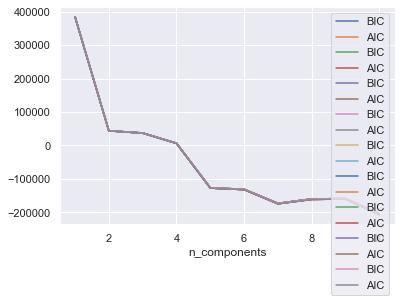

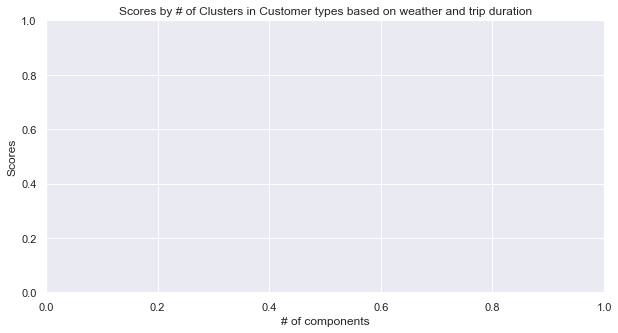

In [87]:
clusters = []
clusters = ['tripCustomerAll', 'weatherDuration', 'bikeDemand', 'bikeAvailability', 'hourDuration', 'weekdayDuration', 'monthDuration']
clusters = ['weatherDuration']

createAllclusters(df_005, clusters)